In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Poisson
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

% matplotlib inline

In [2]:
# Create a Dataframe and drop extra column
df = pd.read_csv('../data/seattle_911_prepped.csv', low_memory=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

df_no_out = pd.read_csv('../data/seattle_911_prepped_no_out.csv', low_memory=False)
df_no_out.drop(['Unnamed: 0'], axis=1, inplace=True)

In [12]:
df.head()

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number,dt_crop,date,time,...,day_num,neighborhood,zone1,zone2,zone3,zone4,zone5,zone6,zone7,seasonality
0,11747 Bartlett Av Ne,Medic Response,2010-06-29 08:00:00,47.713787,-122.283848,NaN,NaN,06/29/2010 08:00:00 AM,2010-06-29,08:00:00,...,0,Matthews Beach,0,1,0,0,0,0,0,1.824157
1,700 6th Av S,Aid Response,2010-06-29 07:49:00,47.596676,-122.326370,NaN,NaN,06/29/2010 07:49:00 AM,2010-06-29,07:49:00,...,0,International District,0,0,0,0,1,0,0,1.824157
2,7751 26th Av Nw,Aid Response,2010-06-29 07:49:00,47.685264,-122.389777,NaN,NaN,06/29/2010 07:49:00 AM,2010-06-29,07:49:00,...,0,Loyal Heights,1,0,0,0,0,0,0,1.824157
3,5241 33rd Av S,Aid Response,2010-06-29 07:50:00,47.554718,-122.290486,NaN,NaN,06/29/2010 07:50:00 AM,2010-06-29,07:50:00,...,0,Mid-Beacon Hill,0,0,0,0,0,0,1,1.824157
4,509 3rd Av,Auto Fire Alarm,2010-06-29 07:50:00,47.602114,-122.330809,NaN,NaN,06/29/2010 07:50:00 AM,2010-06-29,07:50:00,...,0,Pioneer Square,0,0,0,0,1,0,0,1.824157


In [3]:
df2 = df.drop(labels=(['Address', 'Type', 'Report Location', 'Incident Number',
                       'dt_crop', 'neighborhood', 'date2', 'time2', 'weekday',
                       'Latitude', 'Longitude', 'time', 'Datetime', 'date']), axis=1)
df2_no_out = df_no_out.drop(labels=(['Address', 'Type', 'Report Location', 'Incident Number',
                                     'dt_crop', 'neighborhood', 'date2', 'time2', 'weekday',
                                     'Latitude', 'Longitude', 'time', 'Datetime', 'date']), axis=1)
df2.head()

,mariners_home,seahawks_home,sounders_home,trav_holiday,dang_holiday,night,Monday,Saturday,Sunday,Thursday,...,Wednesday,day_num,zone1,zone2,zone3,zone4,zone5,zone6,zone7,seasonality
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.824157
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.824157
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1.824157
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.824157
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.824157


In [15]:
df2.to_csv('../data/model_data.csv')
df2_no_out.to_csv('../data/model_data_no_out.csv')

# Modeling

In [3]:
# R used to fix dataframe for Poisson model
df3 = pd.read_csv('../data/model_data_counted_no_out.csv', low_memory=False)
df3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df3.head()

,mariners_home,seahawks_home,sounders_home,trav_holiday,dang_holiday,night,Monday,Saturday,Sunday,Thursday,...,day_num,zone1,zone2,zone3,zone4,zone5,zone6,zone7,seasonality,freq
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1.824157,20
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1.824157,29
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1.824157,30
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.824157,24
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1.824157,15


In [4]:
df3.columns

Index([u'mariners_home', u'seahawks_home', u'sounders_home', u'trav_holiday',
       u'dang_holiday', u'night', u'Monday', u'Saturday', u'Sunday',
       u'Thursday', u'Tuesday', u'Wednesday', u'day_num', u'zone1', u'zone2',
       u'zone3', u'zone4', u'zone5', u'zone6', u'zone7', u'seasonality',
       u'freq'],
      dtype='object')

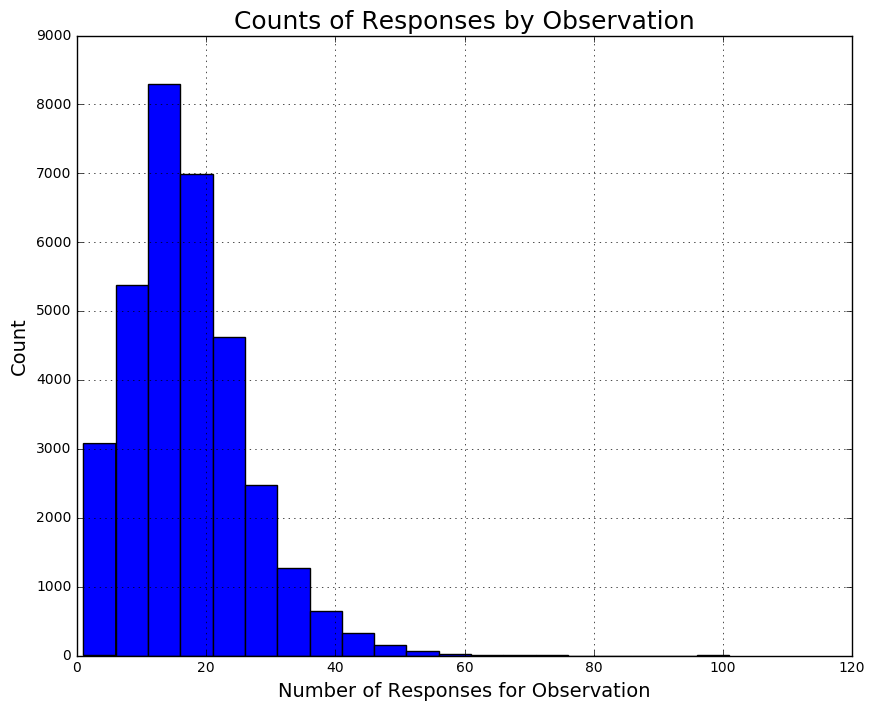

In [28]:
plt.figure(figsize=(10,8))
df3.freq.hist(bins=20)
plt.title('Counts of Responses by Observation', fontsize=18)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Number of Responses for Observation', fontsize=14)

In [5]:
df3.day_num.max()

2303

In [10]:
# Create test and trainging sets
df_train = df3 [df3.day_num < 1938]
df_holdout = df3[(df3.day_num >= 1938) & (df3.day_num <= 2304)]

# Create X and y
y_train = df_train.pop('freq')
X_train = df_train
y_holdout = df_holdout.pop('freq')
X_holdout = df_holdout

# Fit and scale X_train, scale X_holdout
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_holdout = scaler.transform(X_holdout)

In [20]:
def opt_model(X, y, k=5):
    """
    Inputs:
    X = 2D Numpy array of numeric features
    y = 1D Numpy array of numeric counts
    k = Number of folds 
    """
    
    #Create KFold object
    KF = KFold(len(X), n_folds=k, shuffle=False, random_state=None)
    
    # Create lists
    params = []
    preds = []
    scores_ll = []
    scores_pe = []
    
    # Loop over folds and score model using log likelihiood and percent error
    for train_index, test_index in KF:
        model = Poisson(y_train[train_index], X_train[train_index]).fit()
        pred = model.predict(X_train[test_index])
        param = model.params
        
        scores_ll.append(score_log_like(X_train[test_index], y_train[test_index], param))
        scores_pe.append(score_per_err(y_train[test_index], pred))
        params.append(param)
        preds.append(pred)
        
    return preds, scores_ll, scores_pe, params

In [12]:
def score_log_like(X, y, coeffs):
    """
    Inputs: 
    X = 2D Numpy array of numeric features
    y = 1D Numpy array of numeric counts
    coeffs = 1D Pandas series from model.params
    Returns: Score (simplified log likelihood)
    """
    bx = np.dot(X, coeffs)
    lams = -np.exp(bx)
    return lams.sum() + np.dot(y, bx)

In [13]:
def score_per_err(y, y_hat):
    return 100 * (abs(y - y_hat) / y).mean()

In [201]:
preds, scores_ll, scores_pe, params = opt_model(X_train, y_train, 3)

Optimization terminated successfully.
         Current function value: 2.861094
         Iterations 31
Optimization terminated successfully.
         Current function value: 3.195572
         Iterations 31
Optimization terminated successfully.
         Current function value: 3.198418
         Iterations 30
Optimization terminated successfully.
         Current function value: 3.177933
         Iterations 30
Optimization terminated successfully.
         Current function value: 3.181116
         Iterations 28


In [202]:
scores_ll

[137108.99825023534,
 151420.85144429535,
 169755.24011722262,
 183792.63597457344,
 199189.55149374358]

In [23]:
def opt_reg_model(X, y, alphas, k=5):
    """
    Inputs:
    X = 2D Numpy array of numeric features
    y = 1D Numpy array of numeric counts
    alphas = Iterable of alpha values for regularization
    k = Number of folds 
    """
    
    #Create KFold object
    KF = KFold(len(X), n_folds=k, shuffle=False, random_state=None)
    
    params = []
    preds = []
    scores_ll_fold = []
    scores_pe_fold =[]
    scores_ll = []
    scores_pe = []
        
    for alpha in alphas:
        for train_index, test_index in KF:
            model = Poisson(y_train[train_index], X_train[train_index]).fit_regularized(method='l1', alpha=alpha)
            pred = model.predict(X_holdout)
            param = model.params

            scores_ll_fold.append(score_log_like(X_holdout, y_holdout, param))
            scores_pe_fold.append(score_per_err(y_holdout, pred))
            params.append(param)
            preds.append(pred)
        
        scores_ll.append(np.mean(scores_ll_fold))
        scores_pe.append(np.mean(scores_pe_fold))
        
    return preds, scores_ll, scores_pe, params

In [33]:
# Test various alpha values for regularization
alphas = np.linspace(0,0.3)

preds, scores_ll, scores_pe, params = opt_reg_model(X_train, y_train, alphas);

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.86109403296
            Iterations: 29
            Function evaluations: 60
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.19557218958
            Iterations: 30
            Function evaluations: 59
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.1984175639
            Iterations: 27
            Function evaluations: 57
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.17793325995
            Iterations: 29
            Function evaluations: 60
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.18111551789
            Iterations: 28
            Function evaluations: 58
        

In [25]:
# Best alpha value over alpha range 0-100 
alphas[np.argmax(scores_ll)]

4.0816326530612246

In [26]:
# Best alpha value over alpha range 0-100
alphas[np.argmin(scores_pe)]

4.0816326530612246

In [28]:
# Best alpha value over alpha range 0-10
alphas[np.argmax(scores_ll)]

0.0

In [29]:
# Best alpha value over alpha range 0-10
alphas[np.argmin(scores_pe)]

0.0

In [31]:
# Best alpha value over alpha range 0-5
alphas[np.argmax(scores_ll)]

0.0

In [32]:
# Best alpha value over alpha range 0-5
alphas[np.argmin(scores_pe)]

0.0

In [34]:
# Best alpha value over alpha range 0-0.3
alphas[np.argmax(scores_ll)]

0.0

In [35]:
# Best alpha value over alpha range 0-0.3
alphas[np.argmin(scores_pe)]

0.0

# Test w/o Early Noisy Data

In [234]:
df4 = df3[df3.day_num > 400]
df4.reset_index(drop=True, inplace=True)
df4.head()

,mariners_home,seahawks_home,sounders_home,trav_holiday,dang_holiday,night,Monday,Saturday,Sunday,Thursday,...,day_num,zone1,zone2,zone3,zone4,zone5,zone6,zone7,seasonality,freq
0,0,0,0,0,0,1,0,0,0,1,...,401,1,0,0,0,0,0,0,1.999917,39
1,0,0,0,0,0,1,0,0,0,1,...,401,0,0,0,0,0,0,1,1.999917,17
2,0,0,0,0,0,1,0,0,0,1,...,401,0,0,0,0,0,1,0,1.999917,20
3,0,0,0,0,0,1,0,0,0,1,...,401,0,0,1,0,0,0,0,1.999917,14
4,0,0,0,0,0,1,0,0,0,1,...,401,0,0,0,1,0,0,0,1.999917,22


In [235]:
# Create test and trainging sets
df_train = df4[df4.day_num < 1938]
df_holdout = df4[df4.day_num >= 1938]

# Create X and y
y_train = df_train.pop('freq')
X_train = df_train
y_holdout = df_holdout.pop('freq')
X_holdout = df_holdout

# Fit and scale X_train, scale X_holdout
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_holdout = scaler.transform(X_holdout)

In [253]:
# Test various alpha values for regularization
alphas = np.linspace(0,0.3)

preds, scores_ll, scores_pe, params = opt_reg_model(X_train, y_train, alphas);

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.86764219044
            Iterations: 32
            Function evaluations: 61
            Gradient evaluations: 32
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.87237519578
            Iterations: 30
            Function evaluations: 61
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.85666360668
            Iterations: 30
            Function evaluations: 60
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.86286000488
            Iterations: 29
            Function evaluations: 58
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.85232798263
            Iterations: 28
            Function evaluations: 58
       

In [240]:
# Best alpha value over alpha range 0-100
alphas[np.argmax(scores_ll)]

2.0408163265306123

In [241]:
# Best alpha value over alpha range 0-100
alphas[np.argmin(scores_pe)]

0.0

In [243]:
# Best alpha value over alpha range 0-10
alphas[np.argmax(scores_ll)]

0.20408163265306123

In [244]:
# Best alpha value over alpha range 0-10
alphas[np.argmin(scores_pe)]

0.0

In [247]:
# Best alpha value over alpha range 0-1
alphas[np.argmax(scores_ll)]

0.061224489795918366

In [248]:
# Best alpha value over alpha range 0-1
alphas[np.argmin(scores_pe)]

0.020408163265306121

In [254]:
# Best alpha value over alpha range 0-0.3
alphas[np.argmax(scores_ll)]

0.085714285714285715

In [255]:
# Best alpha value over alpha range 0-0.3
alphas[np.argmin(scores_pe)]

0.024489795918367346

# Plots

In [6]:
# Create X and y
y = df3.pop('freq')
X = df3

# Fit and scale X_train, scale X_holdout
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X)

In [8]:
len(X)

33059

In [7]:
model = Poisson(y, X).fit()
y_hat = model.predict(X)

Optimization terminated successfully.
         Current function value: 3.118717
         Iterations 31


In [8]:
df3['y'] = y
df3['y_hat'] = y_hat

In [23]:
# Earliest date in dataset
day0 = date(2010,6,29)

# Create days feature and for regularization by model
df3['Date'] = (pd.to_timedelta(df3.day_num, unit='D') + day0)

df3.head()

,mariners_home,seahawks_home,sounders_home,trav_holiday,dang_holiday,night,Monday,Saturday,Sunday,Thursday,...,zone2,zone3,zone4,zone5,zone6,zone7,seasonality,y,y_hat,Date
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1.824157,20,11.714111,2010-06-29
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1.824157,29,18.439931,2010-06-29
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.824157,30,14.621397,2010-06-29
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1.824157,24,13.296821,2010-06-29
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1.824157,15,13.845642,2010-06-29


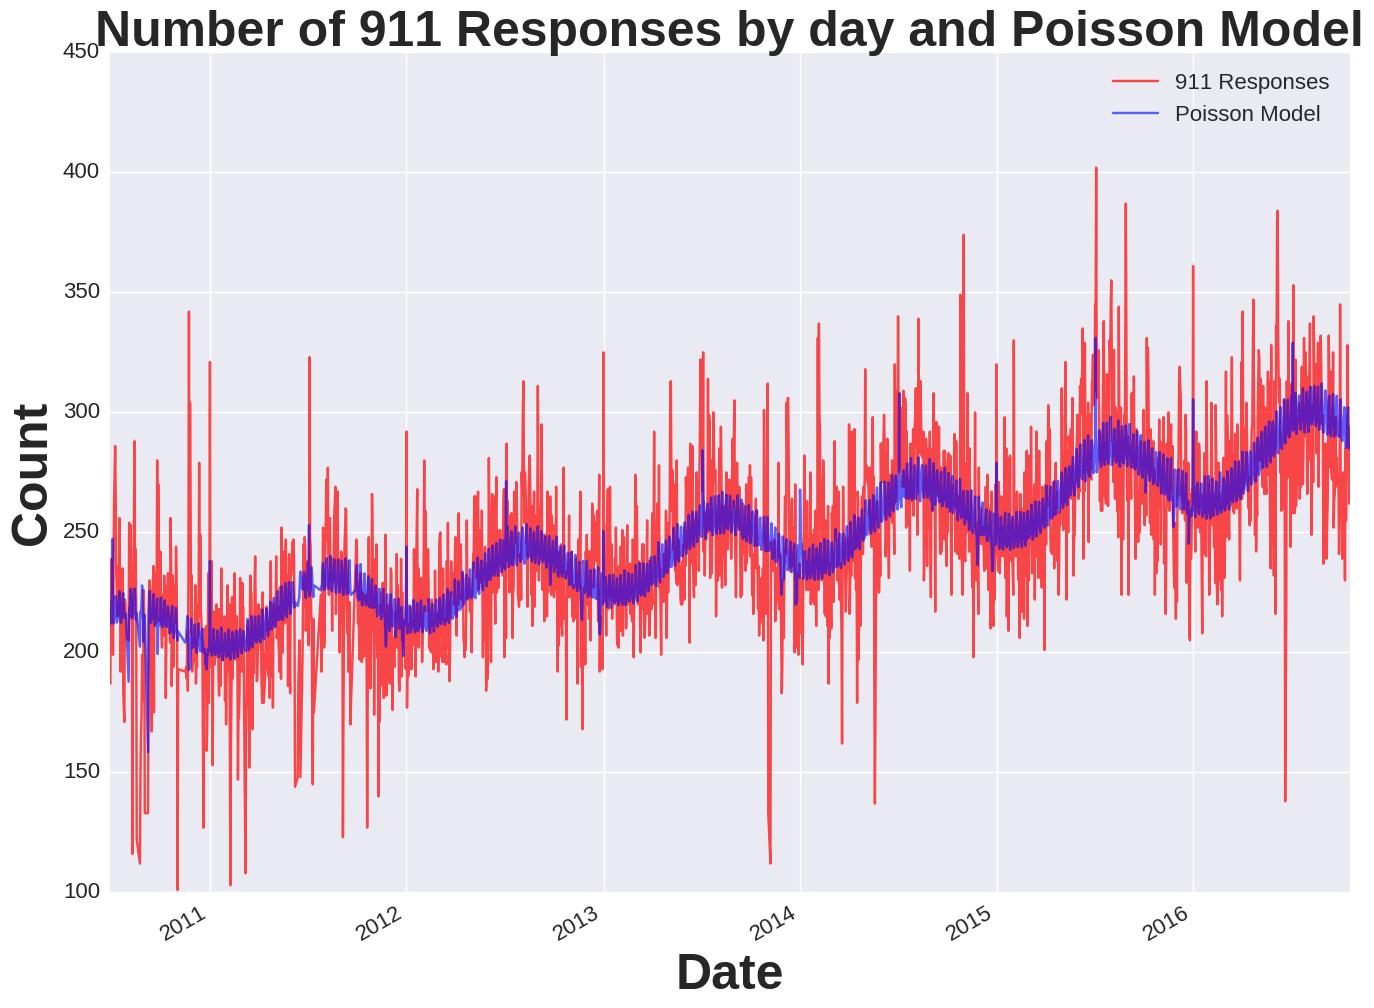

In [25]:
# 911 call counts by day
plt.figure(figsize=(16,12))
plt.xticks(fontsize=16)
plt.xlabel('Date', fontsize=36, fontweight='bold')
plt.yticks(fontsize=16)
plt.ylabel('Count', fontsize=36, fontweight='bold')
plt.title('Number of 911 Responses by day and Poisson Model', fontsize=36, fontweight='bold')
df3.groupby(by='Date').y.sum().plot(color='r', alpha = 0.7);
df3.groupby(by='Date').y_hat.sum().plot(color='b', alpha = 0.6);
plt.legend(['911 Responses', 'Poisson Model'], fontsize=16)
plt.savefig('../images/data_and_model.png')

# Final Model Training

In [ ]:
# Create test and trainging sets
df_train = df3 

# Create X and y
y_train = df_train.pop('freq')
X_train = df_train

# Fit and scale X_train, scale X_holdout
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)